# Driver Analysis
This notebook compares the top 3 drivers in the World Drivers' Championship as of 21 races finished in the 2024 season:
- Max Verstappen (VER): Red Bull Racing
- Lando Norris (NOR): McLaren
- Charles Leclerc (LEC): Ferrari

*This analysis uses data from FastF1 API*

In [73]:
from core.extract import F1DataProcessor
from core.telemetry import F1TelemetryAnalyzer
from core.utils import round_dict, driver_colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Qualifying Performance
We use two datasets here `quali_data` and `quali_telemetry`.
1. `quali_data` contains general information about laps done in qualifying sessions taken from `session.laps` endpoint
2. `quali_telemetry` contains telemetry data about each lap done in qualifying sessions (standardized to have 300 data points per lap) taken from `get_car_data()` endpoint

A Grand Prix qualifying session determines the grid order for Sunday Grand Prix races, and is broken down into three further sessions: Q1, Q2, Q3. Five drivers are knocked out after each Qualifying session, with Q3 being a top-10 shootout for pole position (position 1 on the grid).
<br>
<br>
**quali_data**
- Most of the information in this dataframe is already given by `session.laps` endpoint
- Transformations done: <br>
     (1) Converted `SectorTime` to total seconds<br>
     (2) Added `LapEndDate` to extract accurate corresponding telemetry data<br>
     (3) Added `QualiSession` to determine which qualifying session the lap was set (only fast laps* are considered)<br>
     (4) Added `LapRank` which is the driver's lap's rank at the time of setting it<br>
     (5) Added `DeltaFastestLap` which is the driver's lap's difference from the fastest lap at the time of setting it<br>

q**uali_telemetry**
- Most of the information in this dataframe is already given by `get_car_data` endpoint
- Added identifier columns to merge with `quali_data` (`Round`, `Driver`, `LapNumber`)


*Fast laps are considered the driver's best attempt (no warm-up laps or cool down laps)

In [61]:
processor = F1DataProcessor(cache_dir="cache", year=2024)

# Get normalized qualifying data
quali_data, quali_telemetry = processor.get_quali_session(
    rounds=range(1, 22),
    drivers=["VER", "NOR", "LEC"],
    normalize_telemetry=True, 
    target_points=300
)

core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	No lap data for driver 2
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 2)


In [ ]:
quali_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,QualiSession,LapRank,CurrentFastestLap,DeltaFastestLap,Position
18,1,LEC,16,Ferrari,0 days 00:01:31.260000,2.0,1.0,29.522,39.009,22.729,...,1,False,,2024-03-01 16:02:12.510,2024-03-01 16:03:43.770,1.0,2.0,0 days 00:01:31.208000,0.052,2.0
103,1,NOR,4,McLaren,0 days 00:01:30.143000,2.0,1.0,28.983,38.576,22.584,...,1,False,,2024-03-01 16:08:33.263,2024-03-01 16:10:03.406,1.0,1.0,0 days 00:01:30.143000,0.000,7.0
1,1,VER,1,Red Bull Racing,0 days 00:01:30.031000,2.0,1.0,28.787,38.580,22.664,...,1,False,,2024-03-01 16:08:56.653,2024-03-01 16:10:26.684,1.0,1.0,0 days 00:01:30.031000,0.000,1.0
21,1,LEC,16,Ferrari,0 days 00:01:30.243000,5.0,2.0,29.067,38.589,22.587,...,1,False,,2024-03-01 16:09:51.898,2024-03-01 16:11:22.141,1.0,5.0,0 days 00:01:30.031000,0.212,2.0
4,1,VER,1,Red Bull Racing,0 days 00:01:30.160000,5.0,2.0,28.822,38.767,22.571,...,1,False,,2024-03-01 16:17:45.607,2024-03-01 16:19:15.767,1.0,5.0,0 days 00:01:29.909000,0.251,1.0


In [62]:
quali_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,0 days 00:00:00.107000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,0 days 00:00:00.292418060,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,0 days 00:00:00.507668896,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,0 days 00:00:00.688384615,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,0 days 00:00:00.970501672,1,VER,1


In [16]:
quali_data.groupby(["Driver", "QualiSession"]).LapRank.mean()

Driver  QualiSession
LEC     1.0             13.741176
        2.0              6.875000
        3.0              4.285714
NOR     1.0             15.591549
        2.0              6.975610
        3.0              3.285714
VER     1.0             16.710145
        2.0              5.340426
        3.0              2.658537
Name: LapRank, dtype: float64

In [17]:
quali_results = quali_data[["Round", "Driver", "Position"]].drop_duplicates()
quali_results = quali_results.groupby(["Driver"]).agg({"Position": [("avg_starting_pos", "mean"), "std", ("P1_count", lambda x: (x == 1).sum())]})

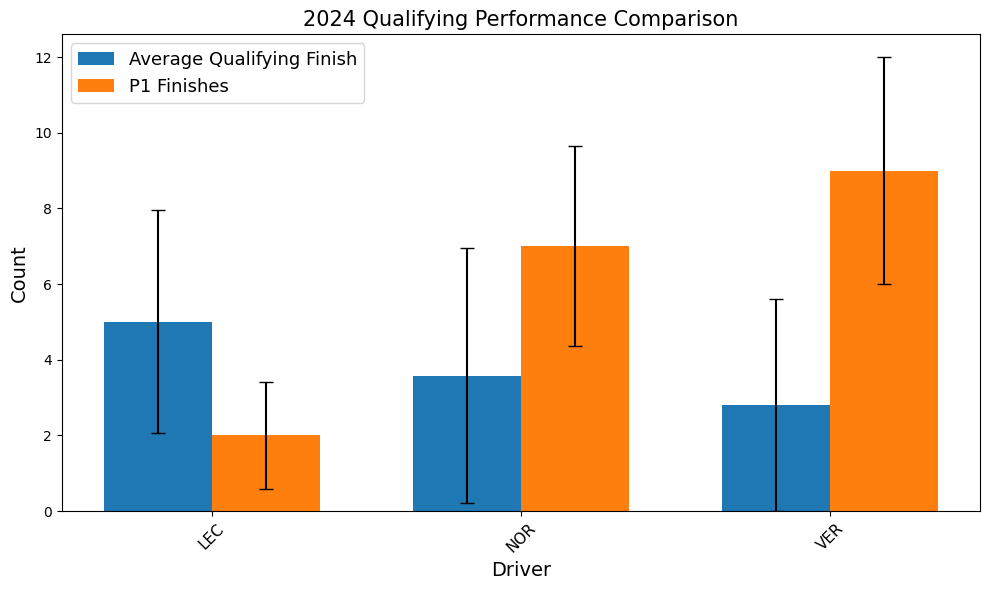

In [18]:
plt.figure(figsize=(10, 6))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], quali_results["Position"]["avg_starting_pos"], width, 
       yerr=quali_results["Position"]["std"], 
       capsize=5,
       label="Average Qualifying Finish")

plt.bar([i + width/2 for i in x], quali_results["Position"]["P1_count"], width,
       yerr=np.sqrt(quali_results["Position"]["P1_count"]),
       capsize=5,
       label="P1 Finishes")

plt.xlabel("Driver", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("2024 Qualifying Performance Comparison", fontsize=15)
plt.xticks(x, quali_results.index, rotation=45, fontsize=11)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

In [31]:
quali_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,1,VER,1


### Last 5 Races Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won

In [32]:
quali_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,1,VER,1


In [33]:
quali_telemetry[quali_telemetry["Driver"]=="VER"]

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,1,VER,1
...,...,...,...,...,...,...,...,...,...,...
295,10643.090301,303.000000,8.0,9.0,100.0,0.0,751506.604779,9,VER,21
296,10688.735786,303.397993,8.0,9.0,100.0,0.0,756493.001137,9,VER,21
297,10679.862876,304.000000,8.0,9.0,100.0,0.0,761506.464905,9,VER,21
298,10683.381271,304.799331,8.0,9.0,100.0,0.0,766552.442051,9,VER,21


In [41]:
sample_telemetry = quali_telemetry[quali_telemetry["Round"]==20]

In [67]:
analyzer = F1TelemetryAnalyzer(n_samples=300)

processed_laps, lap_metrics = analyzer.preprocess_lap_data(
   quali_telemetry,
   rounds=range(10, 16),
   drivers=["VER", "NOR", "LEC"]
)

In [68]:
processed_laps

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round,normalized_time
0,10450.000000,296.000000,8.0,12.0,99.0,0.0,0.000000,0 days 00:00:00.197000,1,LEC,10,0.000000
1,10524.321070,297.812709,8.0,12.0,99.0,0.0,12.079188,0 days 00:00:00.342923077,1,LEC,10,0.003344
2,10616.521739,299.625418,8.0,12.0,99.0,0.0,37.703527,0 days 00:00:00.520541806,1,LEC,10,0.006689
3,10744.578595,302.157191,8.0,12.0,99.0,0.0,79.413707,0 days 00:00:00.730575251,1,LEC,10,0.010033
4,10824.525084,304.250836,8.0,12.0,99.0,0.0,137.623999,0 days 00:00:00.948100334,1,LEC,10,0.013378
...,...,...,...,...,...,...,...,...,...,...,...,...
295,11353.150502,319.963211,8.0,12.0,100.0,0.0,530786.447221,0 days 00:51:07.139849498,4,VER,15,0.986622
296,11348.190635,321.361204,8.0,12.0,100.0,0.0,534472.637441,0 days 00:51:07.357240803,4,VER,15,0.989967
297,11353.785953,322.240803,8.0,12.0,100.0,0.0,538173.286448,0 days 00:51:07.542792642,4,VER,15,0.993311
298,11455.204013,323.120401,8.0,12.0,100.0,0.0,541889.424642,0 days 00:51:07.744264214,4,VER,15,0.996656


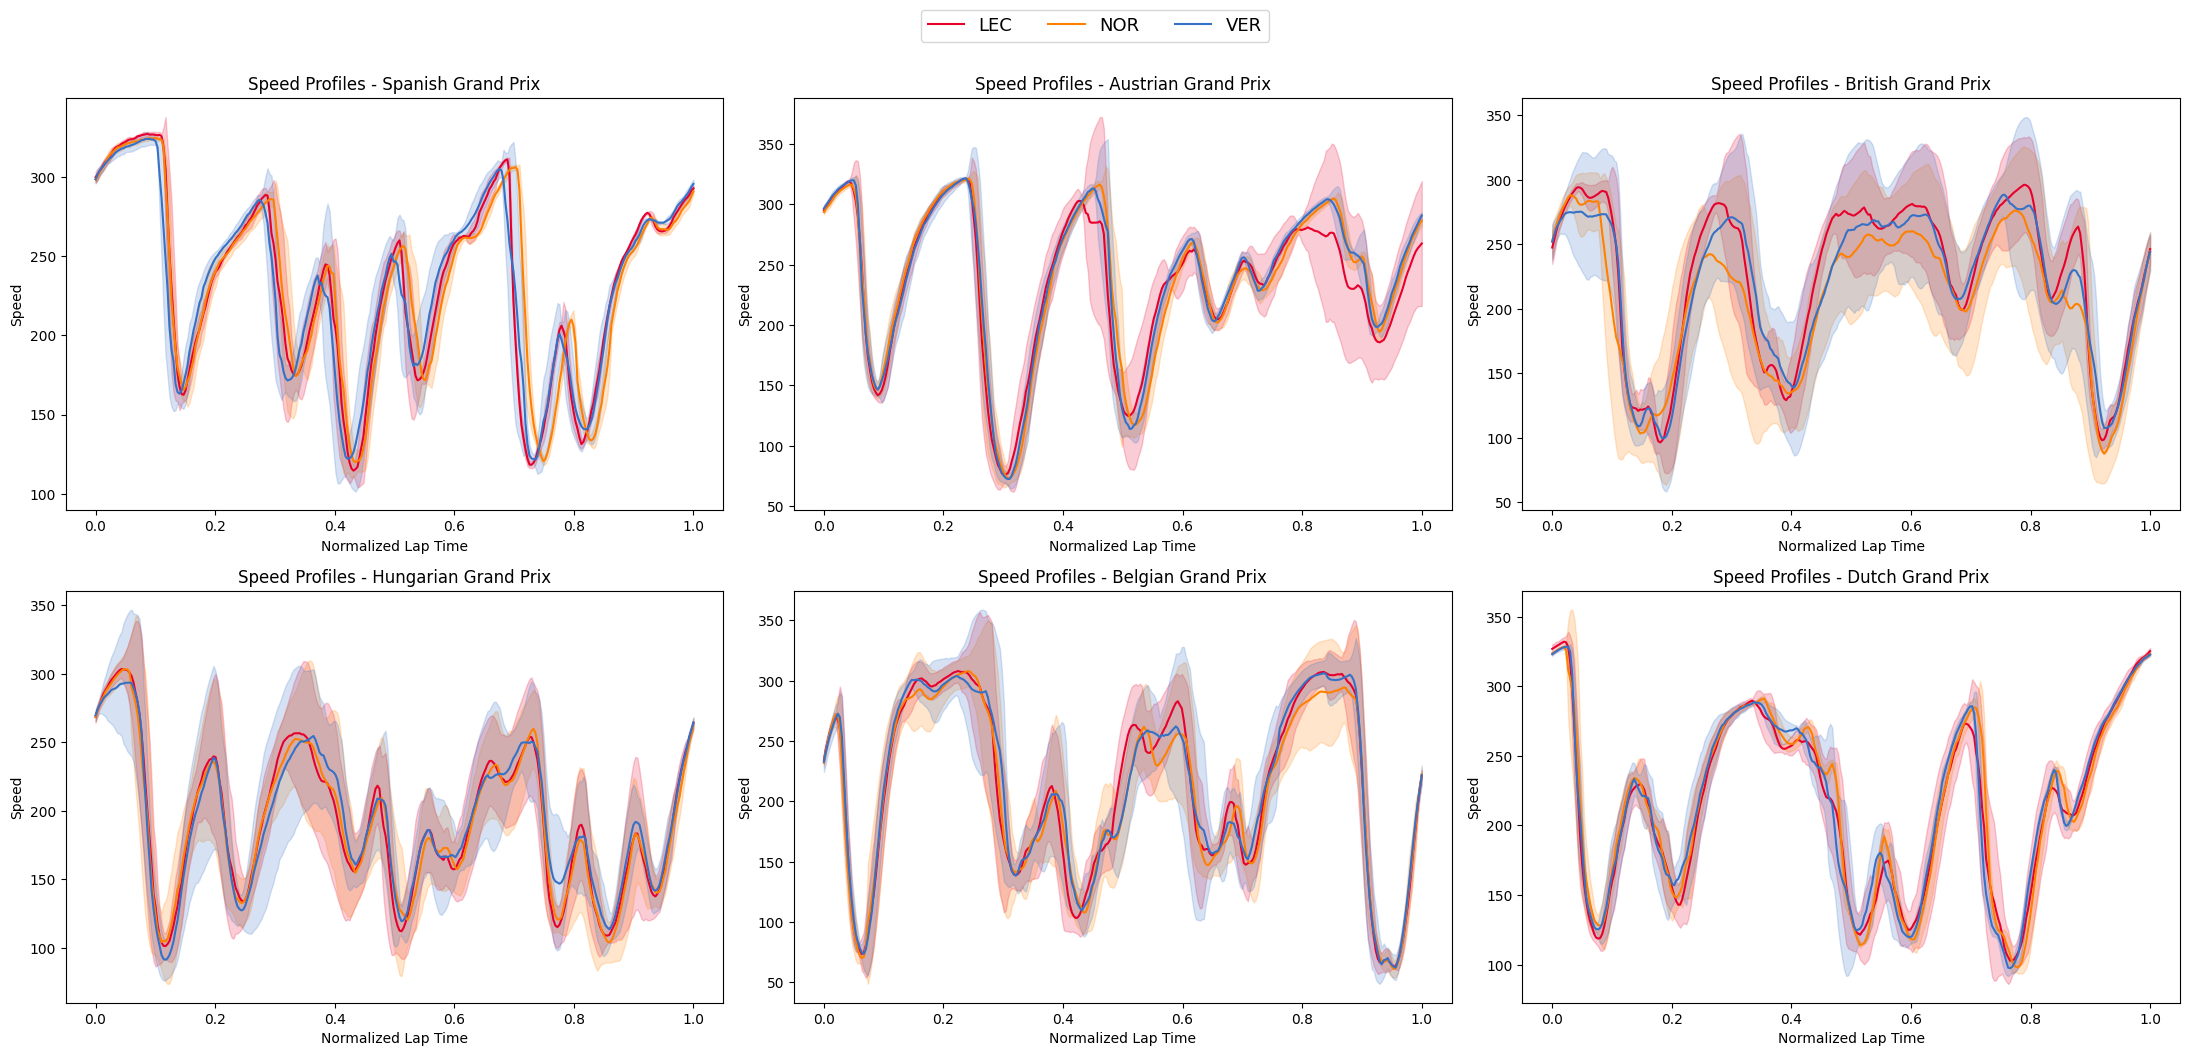

In [ ]:
rounds = processed_laps["Round"].unique()
num_rounds = len(rounds)

# Set number of columns to 3
num_cols = 3
num_rows = (num_rounds + num_cols - 1) // num_cols

# Create figure with extra space on the right for the legend
fig = plt.figure(figsize=(22, 5*num_rows))  # Slightly wider to accommodate legend

for idx, round_num in enumerate(rounds, 1):
    ax = plt.subplot(num_rows, num_cols, idx)
    
    round_data = processed_laps[processed_laps["Round"] == round_num]
    for driver in processed_laps["Driver"].unique():
        driver_data = round_data[round_data["Driver"] == driver]
        grouped = driver_data.groupby("normalized_time")
        mean_speed = grouped["Speed"].mean()
        std_speed = grouped["Speed"].std()

        # Use the driver-specific color for both the line and fill
        driver_color = driver_colors.get(driver)
        plt.plot(driver_data["normalized_time"].unique(),
                mean_speed, 
                label=driver if idx == 1 else "",  # Only include label for first subplot
                color=driver_color)
        plt.fill_between(driver_data["normalized_time"].unique(),
                        mean_speed - std_speed,
                        mean_speed + std_speed,
                        alpha=0.2,
                        color=driver_color)
        
        plt.xlabel("Normalized Lap Time")
        plt.ylabel("Speed")
        plt.title(f"Qualifying Speed Profiles - {round_dict[round_num]}")

fig.legend(bbox_to_anchor=(0.5, 1.01), loc="lower center", ncol=len(driver_colors), fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjusted to leave space at the top for legend

## Race Performance
Similar to qualifying sessions, we use two datasets here `race_data` and `race_telemetry`.

In [3]:
processor = F1DataProcessor(cache_dir="cache", year=2024)

race_data, race_telemetry = processor.get_race_session(
    rounds=range(1, 22),
    drivers=["VER", "NOR", "LEC"],
    normalize_telemetry=True, 
    target_points=300
)

Request for URL https://ergast.com/api/f1/2024/17/results.json failed; using cached response
Traceback (most recent call last):
  File "/Users/katecastillo/Documents/learning/f1-exploration/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/katecastillo/Documents/learning/f1-exploration/.venv/lib/python3.11/site-packages/urllib3/connection.py", line 507, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/katecastillo/.pyenv/versions/3.11.9/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/Users/katecastillo/.pyenv/versions/3.11.9/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/katecastillo/.pyenv/versions/3.11.9/lib/python3.11/http/client.py", l

In [4]:
race_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,Position
0,1,VER,1,Red Bull Racing,0 days 00:01:37.284000,1.0,1.0,NaN,41.266,23.616,...,False,SOFT,4.0,False,12,False,,2024-03-02 15:03:42.342,2024-03-02 15:05:19.626,1.0
1,1,VER,1,Red Bull Racing,0 days 00:01:36.296000,2.0,1.0,30.916,41.661,23.719,...,True,SOFT,5.0,False,1,False,,2024-03-02 15:05:19.941,2024-03-02 15:06:56.237,1.0
2,1,VER,1,Red Bull Racing,0 days 00:01:36.753000,3.0,1.0,30.999,41.966,23.788,...,False,SOFT,6.0,False,1,False,,2024-03-02 15:06:56.237,2024-03-02 15:08:32.990,1.0
3,1,VER,1,Red Bull Racing,0 days 00:01:36.647000,4.0,1.0,30.931,41.892,23.824,...,False,SOFT,7.0,False,1,False,,2024-03-02 15:08:32.990,2024-03-02 15:10:09.637,1.0
4,1,VER,1,Red Bull Racing,0 days 00:01:37.173000,5.0,1.0,31.255,42.056,23.862,...,False,SOFT,8.0,False,1,False,,2024-03-02 15:10:09.637,2024-03-02 15:11:46.810,1.0


In [5]:
race_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,LapNumber,Driver,Round
0,9963.000000,0.000000,1.0,1.0,15.000000,1.000000,0.000000,1,VER,1
1,9464.230769,0.692308,1.0,1.0,15.000000,0.769231,0.046154,1,VER,1
2,7719.615385,6.692308,1.0,1.0,15.000000,0.000000,0.630769,1,VER,1
3,6039.615385,15.153846,1.0,1.0,15.000000,0.000000,2.302564,1,VER,1
4,3884.846154,29.000000,1.0,1.0,19.615385,0.000000,7.450427,1,VER,1


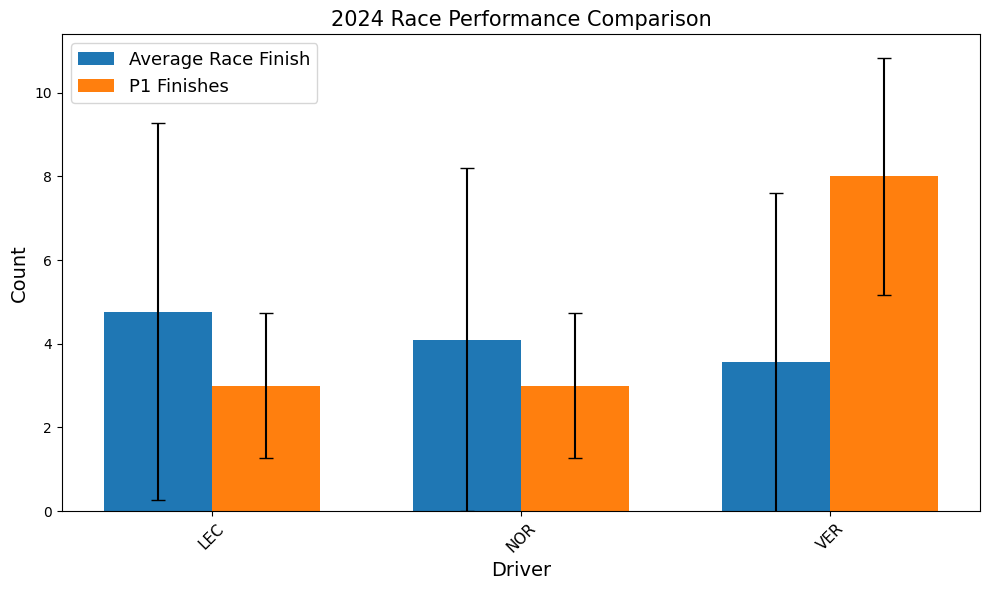

In [25]:
race_results = race_data.groupby(["Round", "Driver"], as_index=False)["Position"].first()
race_results = race_results.groupby("Driver").agg({"Position": [("avg_starting_pos", "mean"), "std", ("P1_count", lambda x: (x == 1).sum())]})

plt.figure(figsize=(10, 6))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], race_results["Position"]["avg_starting_pos"], width, 
       yerr=race_results["Position"]["std"], 
       capsize=5,
       label="Average Race Finish")

plt.bar([i + width/2 for i in x], race_results["Position"]["P1_count"], width,
       yerr=np.sqrt(race_results["Position"]["P1_count"]),
       capsize=5,
       label="P1 Finishes")

plt.xlabel("Driver", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("2024 Race Performance Comparison", fontsize=15)
plt.xticks(x, race_results.index, rotation=45, fontsize=11)
plt.legend(fontsize=13)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

### Last 5 Races Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won